# Model Comparison Analysis

This notebook analyzes `model_comparison_logs/model_comparison_results.csv` and focuses on how caching techniques perform across models.


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

csv_path = "experiment_logs/model_comparison_results_regraded.csv"
df = pd.read_csv(csv_path)
df.shape

(12, 36)

## Basic info and summary

Inspect schema and overall metric distributions.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   6 non-null      object 
 1   experiment                  6 non-null      object 
 2   model                       6 non-null      object 
 3   dataset_config              6 non-null      object 
 4   split                       6 non-null      object 
 5   max_samples                 6 non-null      int64  
 6   shuffle_seed                6 non-null      int64  
 7   chunk_source                6 non-null      object 
 8   prompt_template             6 non-null      object 
 9   similarity_threshold        6 non-null      float64
 10  embedding_layers            6 non-null      object 
 11  embedding_hook              6 non-null      object 
 12  max_cached_blocks           0 non-null      float64
 13  cache_dir                   6 non-null 

In [26]:
metrics = ["avg_latency", "answer_accuracy", "cache_hit_rate", "avg_latency_hit", "avg_latency_miss"]
df[metrics].describe()

,avg_latency,answer_accuracy,cache_hit_rate,avg_latency_hit,avg_latency_miss
count,12.000000,12.000000,12.000000,6.000000,12.000000
mean,0.351460,0.288574,0.265625,0.001351,0.475282
std,0.238069,0.068878,0.277676,0.000224,0.245273
min,0.079748,0.205078,0.000000,0.001125,0.174611
25%,0.204044,0.221680,0.000000,0.001153,0.217647
50%,0.299100,0.303711,0.257812,0.001344,0.479032
75%,0.443762,0.331543,0.523438,0.001540,0.633029
max,0.908009,0.412109,0.546875,0.001596,0.908009


## Define model and technique

We treat `model` as the backbone family, and derive a compact `technique` label from experiment/flags that describe the caching configuration.

In [ ]:
model_col = "model" if "model" in df.columns else "experiment"

technique_cols = [
    "experiment",
    "similarity_threshold",
    "embedding_layers",
    "enable_semantic_text_cache",
    "enable_exact_text_cache",
    "enable_fusion_cache",
]

for col in technique_cols:
    if col not in df.columns:
        print(f"Warning: column '{col}' not found in CSV; dropping from technique definition.")

technique_cols = [c for c in technique_cols if c in df.columns]

df["technique"] = (
    df[technique_cols]
    .astype(str)
    .agg(" | ".join, axis=1)
    if technique_cols
    else df["experiment"].astype(str)
)

df[[model_col, "technique"] + metrics].head(12)

,model,technique,avg_latency,answer_accuracy,cache_hit_rate,avg_latency_hit,avg_latency_miss
0,Qwen/Qwen3-VL-8B-Instruct,"qwen3vl-8b-allcache | 0.8 | prompt:384:0.8,vis...",0.366169,0.318359,0.515625,0.001548,0.754314
1,Qwen/Qwen3-VL-4B-Instruct,"qwen3vl-4b-allcache | 0.8 | prompt:384:0.8,vis...",0.208467,0.240234,0.515625,0.001596,0.428684
2,Qwen/Qwen3-VL-2B-Instruct,"qwen3vl-2b-allcache | 0.8 | prompt:384:0.8,vis...",0.346933,0.205078,0.515625,0.001516,0.714636
3,Qwen/Qwen3-VL-8B-Instruct,"qwen3vl-8b-nocache | 0.8 | prompt:384:0.8,visi...",0.908009,0.412109,0.000000,NaN,0.908009
4,Qwen/Qwen3-VL-4B-Instruct,"qwen3vl-4b-nocache | 0.8 | prompt:384:0.8,visi...",0.415222,0.355469,0.000000,NaN,0.415222


## Aggregates: technique effectiveness per model

Compute mean metrics grouped by model and technique to see how each configuration scales across different model sizes/families.

In [14]:
grouped = (
    df.groupby([model_col, "technique"])[metrics]
    .mean()
    .reset_index()
)
grouped.sort_values(["technique", model_col])

,model,technique,avg_latency,answer_accuracy,cache_hit_rate
0,OpenGVLab/InternVL3_5-2B-Instruct,"internvl35-2b-allcache | 0.8 | prompt:384:0.8,...",0.556948,0.306641,0.521484
1,OpenGVLab/InternVL3_5-4B-Instruct,"internvl35-4b-allcache | 0.8 | prompt:384:0.8,...",0.234537,0.328125,0.521484
2,OpenGVLab/InternVL3_5-8B-Instruct,"internvl35-8b-allcache | 0.8 | prompt:384:0.8,...",0.375175,0.341797,0.521484
3,Qwen/Qwen3-VL-2B-Instruct,"qwen3vl-2b-allcache | 0.8 | prompt:384:0.8,vis...",0.265284,0.320312,0.482422
4,Qwen/Qwen3-VL-4B-Instruct,"qwen3vl-4b-allcache | 0.8 | prompt:384:0.8,vis...",0.265015,0.365234,0.482422
5,Qwen/Qwen3-VL-8B-Instruct,"qwen3vl-8b-allcache | 0.8 | prompt:384:0.8,vis...",0.678874,0.416016,0.482422


## Accuracy vs latency: by model and technique

Scatter plots faceted by model show the trade-off between accuracy and latency for each technique.

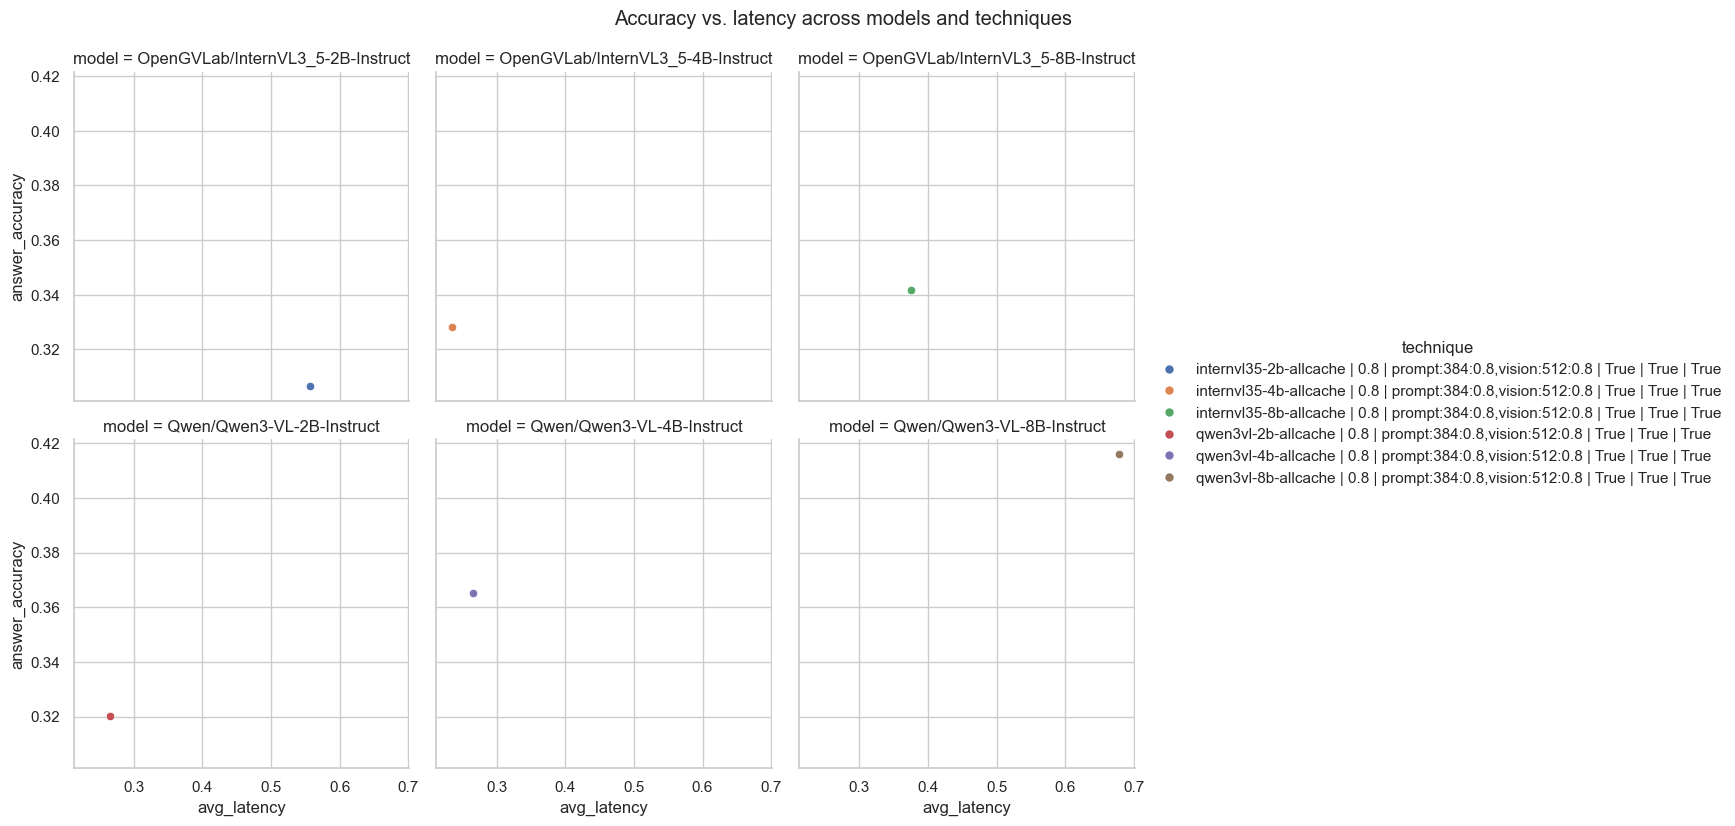

In [15]:
g = sns.relplot(
    data=grouped,
    x="avg_latency",
    y="answer_accuracy",
    hue="technique",
    col=model_col,
    kind="scatter",
    col_wrap=3,
    height=4,
)
g.fig.suptitle("Accuracy vs. latency across models and techniques", y=1.03)
plt.show()

## Accuracy vs hit rate: by model and technique

This view emphasizes how cache utilization (hit rate) translates to accuracy for different backbones.

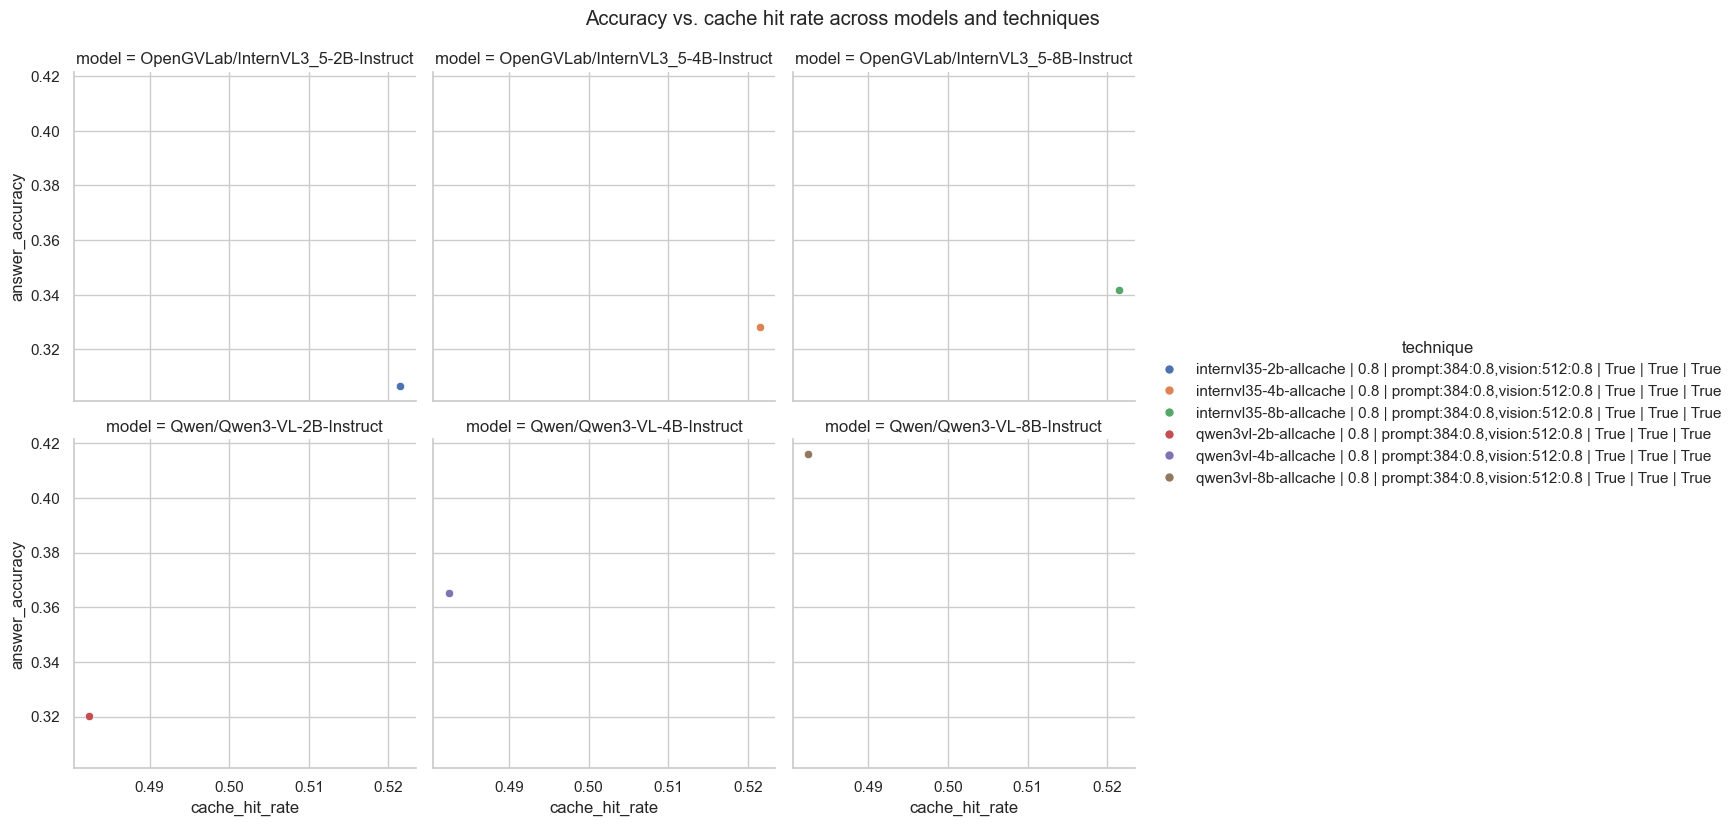

In [16]:
g = sns.relplot(
    data=grouped,
    x="cache_hit_rate",
    y="answer_accuracy",
    hue="technique",
    col=model_col,
    kind="scatter",
    col_wrap=3,
    height=4,
)
g.fig.suptitle("Accuracy vs. cache hit rate across models and techniques", y=1.03)
plt.show()

## Technique rankings per model

Rank techniques within each model by accuracy (and then latency) to summarize which caching strategies work best for which model sizes.

In [17]:
ranked = grouped.sort_values(
    by=[model_col, "answer_accuracy", "avg_latency"],
    ascending=[True, False, True],
)
ranked.reset_index(drop=True).head(50)

,model,technique,avg_latency,answer_accuracy,cache_hit_rate
0,OpenGVLab/InternVL3_5-2B-Instruct,"internvl35-2b-allcache | 0.8 | prompt:384:0.8,...",0.556948,0.306641,0.521484
1,OpenGVLab/InternVL3_5-4B-Instruct,"internvl35-4b-allcache | 0.8 | prompt:384:0.8,...",0.234537,0.328125,0.521484
2,OpenGVLab/InternVL3_5-8B-Instruct,"internvl35-8b-allcache | 0.8 | prompt:384:0.8,...",0.375175,0.341797,0.521484
3,Qwen/Qwen3-VL-2B-Instruct,"qwen3vl-2b-allcache | 0.8 | prompt:384:0.8,vis...",0.265284,0.320312,0.482422
4,Qwen/Qwen3-VL-4B-Instruct,"qwen3vl-4b-allcache | 0.8 | prompt:384:0.8,vis...",0.265015,0.365234,0.482422
5,Qwen/Qwen3-VL-8B-Instruct,"qwen3vl-8b-allcache | 0.8 | prompt:384:0.8,vis...",0.678874,0.416016,0.482422
